# Performance assessment


## Determine binary classification statistics 

For the v3 site filter, vs:
- phase 2 accessibility map
- permissive (100% pass, 0 fail)

based on:
- Mendelian error in all crosses (autosomes)
- male het calls (`n_male_het`, `all_males_called`) will be used instead of `mendel_error`

In [1]:
# Imports:
import gcsfs
import zarr
import dask.array as da
from dask.distributed import Client
import pandas as pd
import numpy as np
import numba
from pathlib import Path
#
import ag3
import ag2

In [2]:
# Settings:
cross_family_ids = ['18-5', '29-2', '36-9', '37-3', '42-4', '45-1', '46-9', '47-6', '73-2', '78-2', '80-2', 'B5', 'K2', 'K4', 'K6']
chrom_arms = ['2R', '2L', '3R', '3L', 'X']

In [3]:
cross_family_ids

['18-5',
 '29-2',
 '36-9',
 '37-3',
 '42-4',
 '45-1',
 '46-9',
 '47-6',
 '73-2',
 '78-2',
 '80-2',
 'B5',
 'K2',
 'K4',
 'K6']

## Determine which crosses stats (inc. Mendelian error) are predicted by each site filter

Populate the confusion matrix, such that:
- If the crosses stats imply that a position is accessible ("good") and the site filter also says it passes, then mark the prediction as a `True Positive` (`TP`)
- If the crosses stats imply that a position is accessible ("good") but the site filter says it fails, then mark the prediction as a `False Negative` (`FN`)
- If the crosses stats imply that a position is inaccessible ("bad") and the site filter also says it fails, then mark the prediction as a `True Negative` (`TN`)
- If the crosses stats imply that a position is inaccessible ("bad") but the site filter says it passes, then mark the prediction as a `False Positive` (`FP`)
- If the crosses stats cannot determine whether a position is "good" or "bad" (e.g. there were no male het calls on the X chromosome, but not all samples were called), then mark the prediction result as undetermined and exclude from subsequent stats.

In [4]:
@numba.njit
def cross_tab_values(eval_arr, test_arr):
    
    out = np.zeros((2, 2))
    
    # TN FP
    # FN TP
    
    # eval arr has 
    for i in range(eval_arr.shape[0]):
        if eval_arr[i] == -1:
            continue
        
        if test_arr[i]:
            out[eval_arr[i], 1] += 1
        else:
            out[eval_arr[i], 0] += 1
    
    return out.reshape((1, 2, 2))

In [5]:
ag3_release_data = ag3.release_data()

def load_phase3_accessibility(chrom):
    return ag3_release_data.load_mask(chrom, mask_id='gamb_colu')

In [6]:
ag2_release_data = ag2.release_data()

def load_phase2_accessibility(chrom):
    
    phase2_is_accessible = ag2_release_data.load_is_accessible(chrom)
    filter_n = ag2_release_data.load_filter_n(chrom)
    phase2_is_accessible_nonN = da.compress(~filter_n, phase2_is_accessible, axis=0)

    # Compute chunk sizes avoids this error when concatenating arrays: ValueError: Arrays chunk sizes are unknown: (nan,)
    phase2_is_accessible_nonN.compute_chunk_sizes() 
    return phase2_is_accessible_nonN

In [7]:
def load_ground_truth(chrom, xid):
    
    if chrom == "X":
        
        # do something
        any_het = ag3_release_data.load_crosses(chrom, xid, "n_male_het")
        is_all_called = ag3_release_data.load_crosses(chrom, xid, "all_males_called")
        
        return da.where(any_het > 0, 0, da.where(is_all_called, 1, -1))

    else:
        me = ag3_release_data.load_crosses(chrom, xid, 'mendel_error')
        called = ag3_release_data.load_crosses(chrom, xid, 'n_samples_called')
    
        return da.where(me > 0, 0, da.where(called == da.max(called), 1, -1))

In [8]:
def calculate_metrics_of_interest(true_neg, false_pos, false_neg, true_pos):
    
    r = {}
    r["tpr"] = true_pos / (true_pos + false_neg)
    r["fpr"] = false_pos / (false_pos + true_neg)
    r["fdr"] = false_pos / (true_pos + false_pos)
    r["tnr"] = 1 - (false_pos / (false_pos + true_neg))
    r["youden"] = r["tpr"] + r["tnr"] - 1
    
    return r

In [9]:
chrom_arms

['2R', '2L', '3R', '3L', 'X']

In [10]:
cross_family_ids

['18-5',
 '29-2',
 '36-9',
 '37-3',
 '42-4',
 '45-1',
 '46-9',
 '47-6',
 '73-2',
 '78-2',
 '80-2',
 'B5',
 'K2',
 'K4',
 'K6']

In [11]:
desired_chunks = (500_000,)

In [12]:
%%time # Wall time: 41min 33s
data_holder = {}

for chrom_arm in chrom_arms:
        
    # varies by chrom only, but need to be chunked depending on ground_truth
    alternative_calls = {
        "phase2": load_phase2_accessibility(chrom_arm).rechunk(desired_chunks),
        "phase3": load_phase3_accessibility(chrom_arm).rechunk(desired_chunks)
    }
    
    alternative_calls["r100"] = da.ones(alternative_calls["phase2"].shape[0], dtype=np.bool, chunks=desired_chunks)
    
    chunks = ((1, ) * alternative_calls["phase2"].numblocks[0], 2, 2)
    x = da.map_blocks(
        cross_tab_values, 
        alternative_calls["phase2"].astype("int"), 
        alternative_calls["phase3"], 
        chunks=chunks,
        dtype=np.int32,
        new_axis=[1, 2]).sum(axis=0).compute()

    for cross_id in cross_family_ids:
        
        print("processing", chrom_arm, cross_id)

        # varies by cross and chrom
        ground_truth = load_ground_truth(chrom_arm, cross_id).rechunk(desired_chunks)


        for key, eval_data in alternative_calls.items():
            
            if (key, chrom_arm, cross_id) in data_holder:
                print("skipping", (key, chrom_arm, cross_id))
                continue

            chunks = ((1, ) * ground_truth.numblocks[0], 2, 2)
            q = da.map_blocks(
                cross_tab_values, 
                ground_truth, 
                eval_data, 
                chunks=chunks, 
                dtype=np.int32, 
                new_axis=[1, 2]).sum(axis=0)

            (tn, fp), (fn, tp) = q.compute()

            res = calculate_metrics_of_interest(tn, fp, fn, tp)
            res["frac_accessible"] = eval_data.mean().compute()

            data_holder[key, chrom_arm, cross_id] = pd.Series(res, dtype=np.float)

processing 2R 18-5
processing 2R 29-2
processing 2R 36-9
processing 2R 37-3
processing 2R 42-4
processing 2R 45-1
processing 2R 46-9
processing 2R 47-6
processing 2R 73-2
processing 2R 78-2
processing 2R 80-2
processing 2R B5
processing 2R K2
processing 2R K4
processing 2R K6
processing 2L 18-5
processing 2L 29-2
processing 2L 36-9
processing 2L 37-3
processing 2L 42-4
processing 2L 45-1
processing 2L 46-9
processing 2L 47-6
processing 2L 73-2
processing 2L 78-2
processing 2L 80-2
processing 2L B5
processing 2L K2
processing 2L K4
processing 2L K6
processing 3R 18-5
processing 3R 29-2
processing 3R 36-9
processing 3R 37-3
processing 3R 42-4
processing 3R 45-1
processing 3R 46-9
processing 3R 47-6
processing 3R 73-2
processing 3R 78-2
processing 3R 80-2
processing 3R B5
processing 3R K2
processing 3R K4
processing 3R K6
processing 3L 18-5
processing 3L 29-2
processing 3L 36-9
processing 3L 37-3
processing 3L 42-4
processing 3L 45-1
processing 3L 46-9
processing 3L 47-6
processing 3L 73-

In [13]:
df = pd.concat(data_holder, axis=0, sort=False, names=["description", "chrom", "cross_id", "metric"])
df.name = "value"

In [14]:
df

description  chrom  cross_id  metric         
phase2       2R     18-5      tpr                0.741824
                              fpr                0.250364
                              fdr                0.004350
                              tnr                0.749636
                              youden             0.491460
                                                   ...   
r100         X      K6        fpr                1.000000
                              fdr                0.019952
                              tnr                0.000000
                              youden             0.000000
                              frac_accessible    1.000000
Name: value, Length: 1350, dtype: float64

In [15]:
output = pd.pivot_table(
    pd.DataFrame(df).reset_index(level="metric"), 
    index=["description", "chrom", "cross_id"], 
    columns="metric", 
    values="value")

In [16]:
output

metric                           fdr       fpr  frac_accessible       tnr  \
description chrom cross_id                                                  
phase2      2L    18-5      0.004120  0.210021         0.580992  0.789979   
                  29-2      0.005933  0.220304         0.580992  0.779696   
                  36-9      0.001676  0.098058         0.580992  0.901942   
                  37-3      0.002049  0.106601         0.580992  0.893399   
                  42-4      0.000920  0.091588         0.580992  0.908412   
...                              ...       ...              ...       ...   
r100        X     80-2      0.032832  1.000000         1.000000  0.000000   
                  B5        0.033012  1.000000         1.000000  0.000000   
                  K2        0.027967  1.000000         1.000000  0.000000   
                  K4        0.021162  1.000000         1.000000  0.000000   
                  K6        0.019952  1.000000         1.000000  0.000000   

metric                           tpr    youden  
description chrom cross_id                      
phase2      2L    18-5      0.644741  0.434720  
                  29-2      0.661733  0.441429  
                  36-9      0.651834  0.553776  
                  37-3      0.650019  0.543419  
                  42-4      0.644396  0.552808  
...                              ...       ...  
r100        X     80-2      1.000000  0.000000  
                  B5        1.000000  0.000000  
                  K2        1.000000  0.000000  
                  K4        1.000000  0.000000  
                  K6        1.000000  0.000000  

[225 rows x 6 columns]

In [18]:
output.to_csv("../data/performance_stats_all.csv")

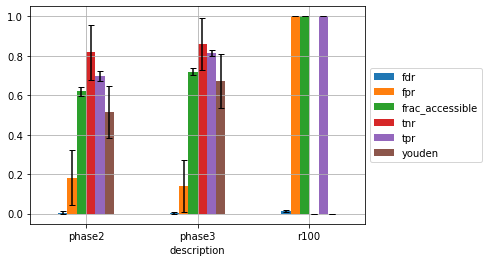

In [43]:
output.groupby(['description']).mean().plot(kind='bar', grid=True, rot=0, yerr=output.groupby(['description']).std(), capsize=3).legend(loc='center left', bbox_to_anchor=(1.0, 0.5))